In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import gp

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled, CuDNN 4007)
/home/d/nolearn/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
input_image, input_prob, input_gold, input_rhoana, dojo_bbox = gp.Legacy.read_dojo_data() 


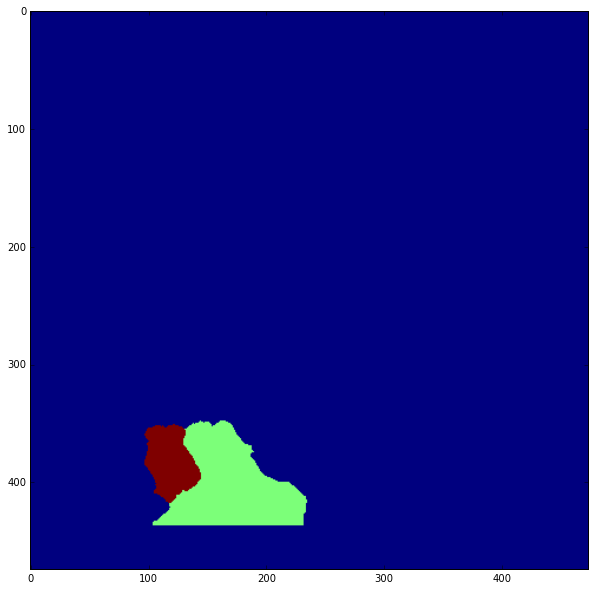

In [4]:
gp.Util.view_labels(input_rhoana[8], [68,70], crop=False)


In [5]:
binary = gp.Util.view_labels(input_rhoana[8], [68,70], crop=False, return_it=True)
splitted = np.array(binary)

In [6]:
binary[binary==1] = 2

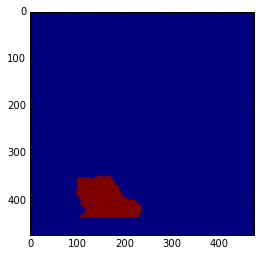

In [7]:
imshow(binary)

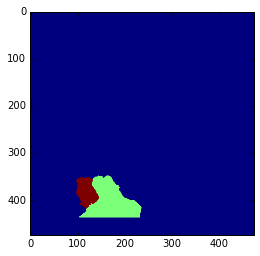

In [8]:
imshow(splitted)

In [9]:
gp.Util.vi(binary.astype(np.uint64), input_gold[8].astype(np.uint64))

0.9781710987371827

In [10]:
gp.Util.vi(splitted.astype(np.uint64), input_gold[8].astype(np.uint64))

1.1039548495432179

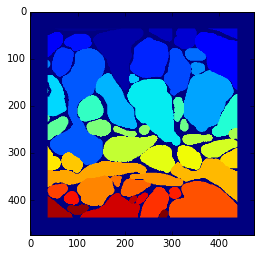

In [11]:
imshow(input_gold[8])

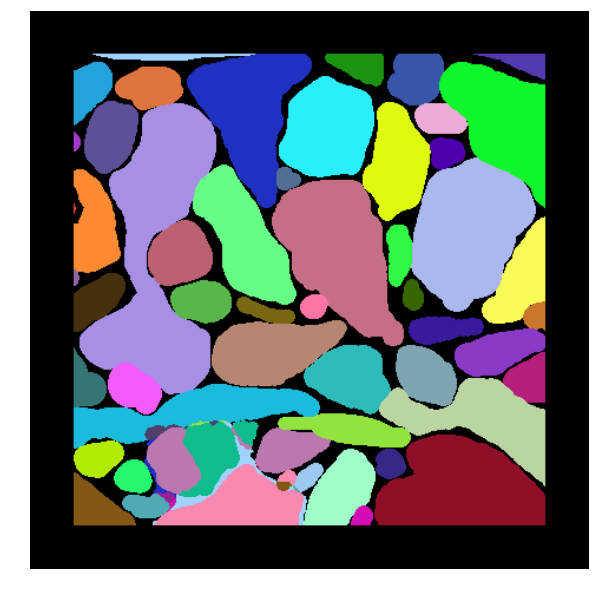

In [16]:
gp.Util.view((input_gold[8] + splitted).astype(np.uint64),large=True)

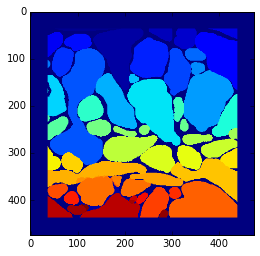

In [17]:
imshow(input_gold[8] + binary)

In [18]:
splitted1 = np.array(splitted)
splitted2 = np.array(splitted)

In [19]:
splitted1[splitted1==1] = 0

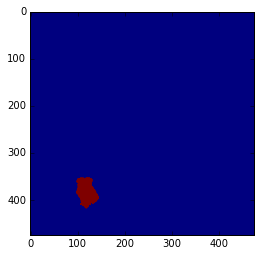

In [20]:
imshow(splitted1)

In [21]:
splitted2[splitted2==2] = 0

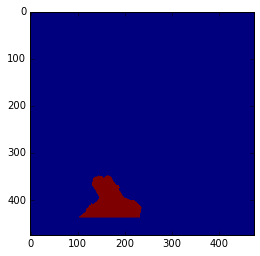

In [22]:
imshow(splitted2)

In [23]:
gp.Util.vi(splitted1.astype(np.uint64), input_gold[8].astype(np.uint64))

0.47895063243286246

In [24]:
gp.Util.vi(splitted2.astype(np.uint64), input_gold[8].astype(np.uint64))

0.8530532196776562

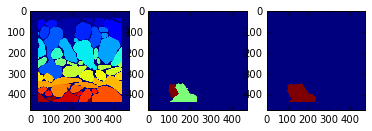

In [26]:
plt.subplot(1,3,1)
imshow(input_gold[8])
plt.subplot(1,3,2)
imshow(splitted)
plt.subplot(1,3,3)
imshow(binary)


In [27]:
input_gold.dtype

dtype('uint32')

In [28]:
splitted.dtype

dtype('float64')

In [29]:
binary.dtype

dtype('float64')

In [36]:
gp.Util.vi(splitted.astype(np.uint64).flatten(), input_gold[8].astype(np.uint64).flatten())

1.1039548495432179

In [33]:
gp.Util.vi(binary.astype(np.uint64).flatten(), input_gold[8].astype(np.uint64).flatten())

0.9781710987371827

In [46]:
print np.unique(binary)
print np.unique(splitted)
print np.unique(input_gold[8])

[ 0.  2.]
[ 0.  1.  2.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56]


In [15]:
test = input_gold[8]*(binary>0)
print np.unique(test)

[ 0 41 43 44 45 50 51 52 53 55]


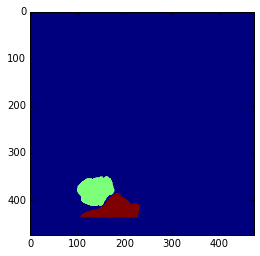

In [16]:
# 43, 52

gt = np.zeros_like(test)
gt[test==43] = 1
gt[test==52] = 2

imshow(gt)

In [17]:
gp.Util.vi(binary.astype(np.uint64).flatten(), gt.astype(np.uint64).flatten())

0.6931450975260867

In [18]:
gp.Util.vi(splitted.astype(np.uint64).flatten(), gt.astype(np.uint64).flatten())

0.8416733242191282

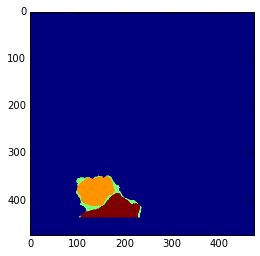

In [19]:
imshow(binary+gt)

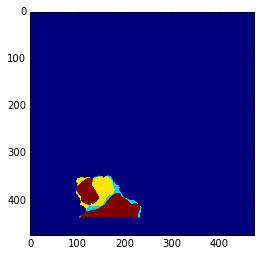

In [20]:
imshow(splitted+gt)

In [21]:
test = binary.copy()
test[gt==1] = 5

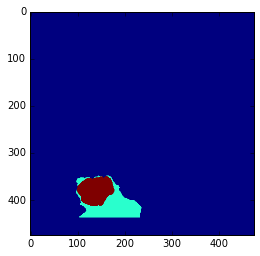

In [22]:
imshow(test)

In [23]:
gp.Util.vi(test.astype(np.uint64).flatten(), gt.astype(np.uint64).flatten())

0.0

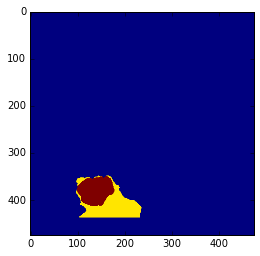

In [24]:
mask = test==5
imshow(mask+binary)

In [25]:
gp.Util.vi((mask+binary).astype(np.uint64).flatten(), gt.astype(np.uint64).flatten())

0.0

In [26]:
import mahotas

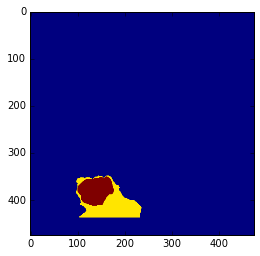

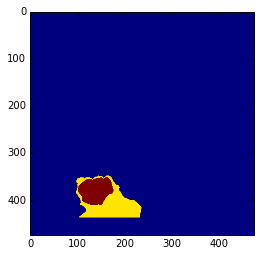

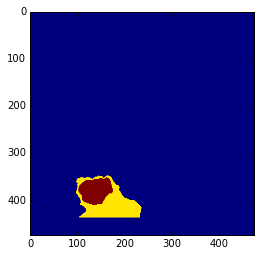

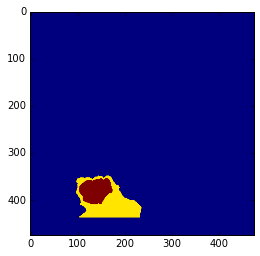

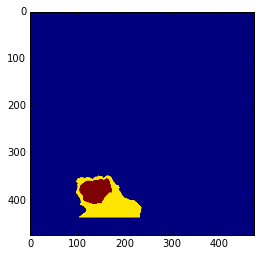

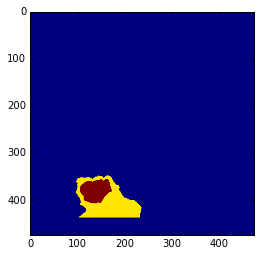

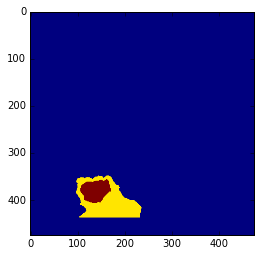

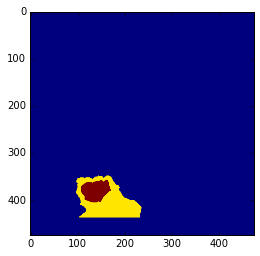

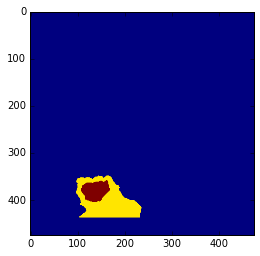

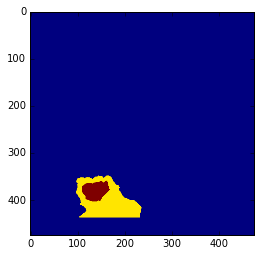

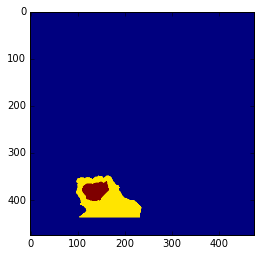

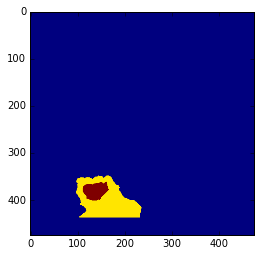

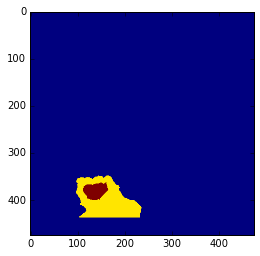

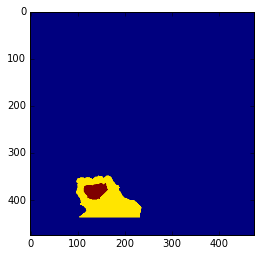

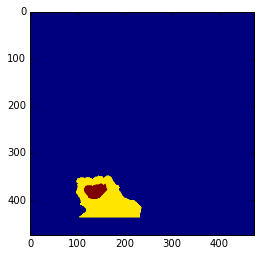

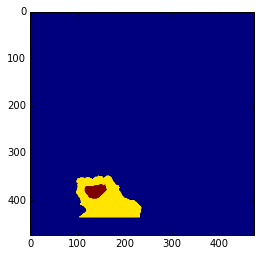

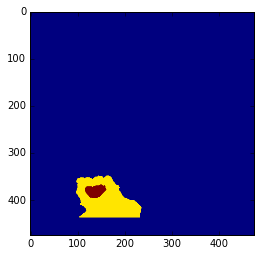

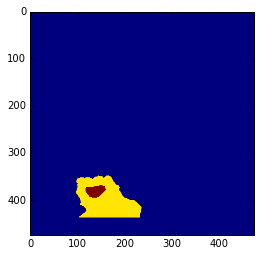

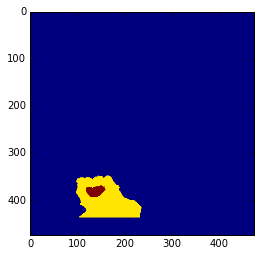

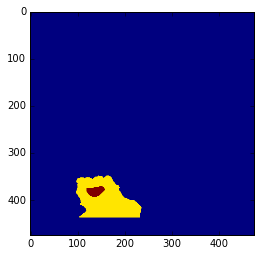

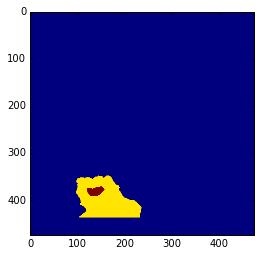

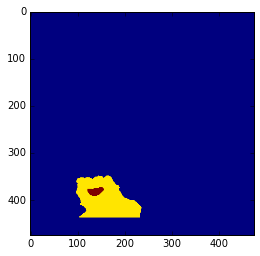

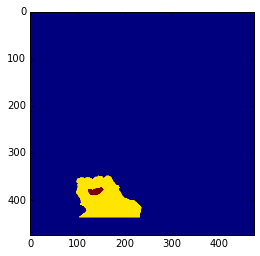

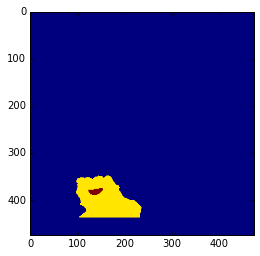

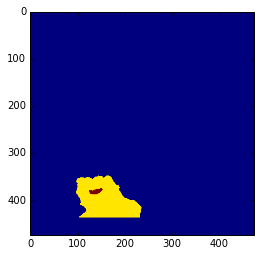

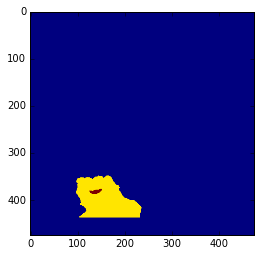

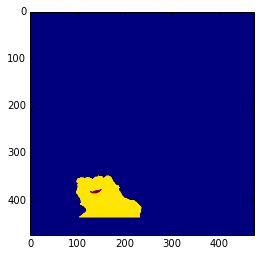

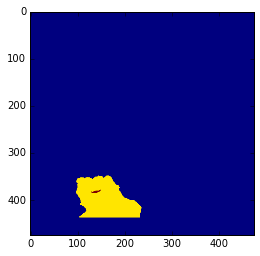

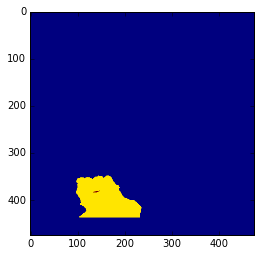

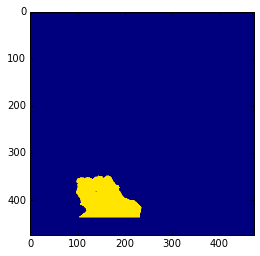

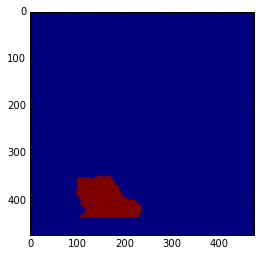

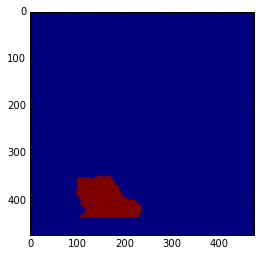

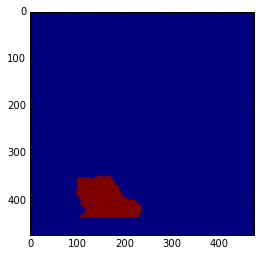

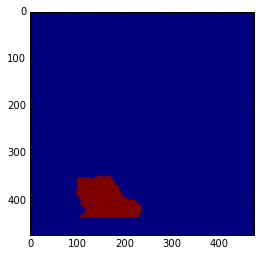

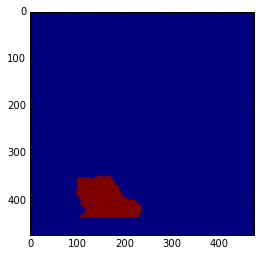

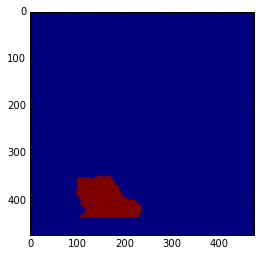

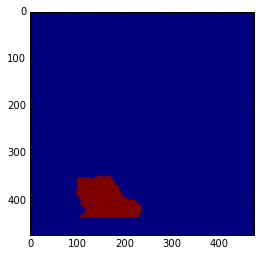

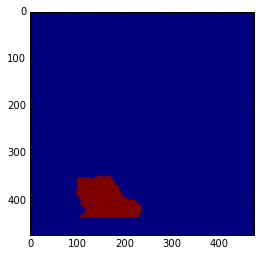

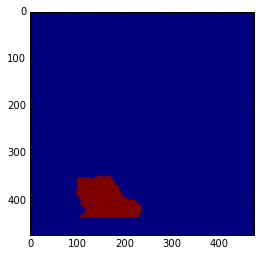

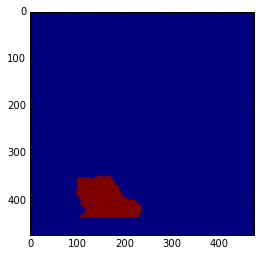

In [27]:
mask = test==5
mask_orig = mask.copy()
values = []

for i in xrange(40):
    mask = mahotas.erode(mask)
    vi = gp.Util.vi((mask+binary).astype(np.uint64).flatten(), gt.astype(np.uint64).flatten())
    #print i, vi
    values.append(vi)
    imshow(mask+binary)
    plt.show()

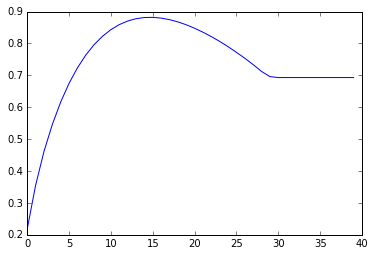

In [28]:
plt.plot(values)

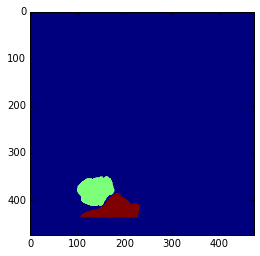

In [116]:
imshow(gt)

In [30]:
import partition_comparison

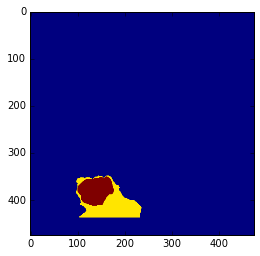

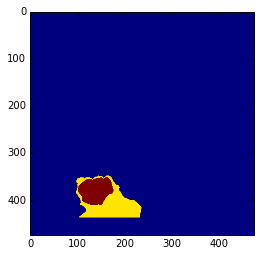

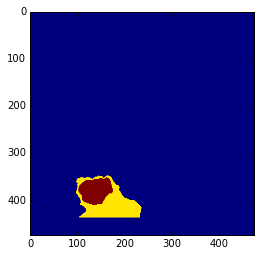

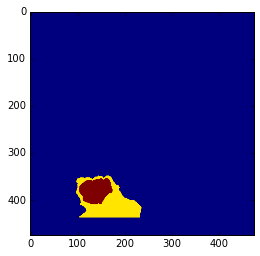

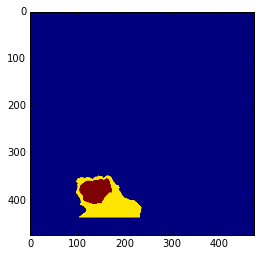

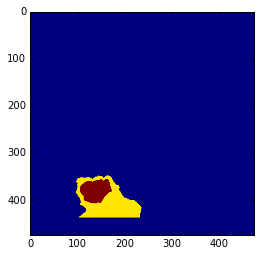

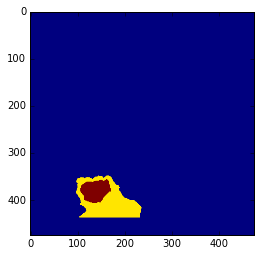

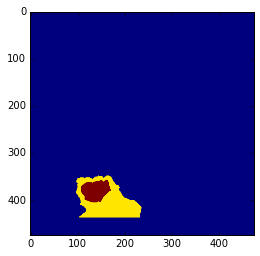

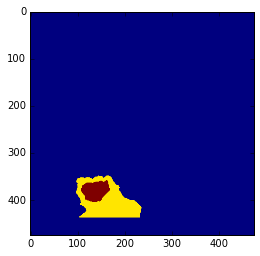

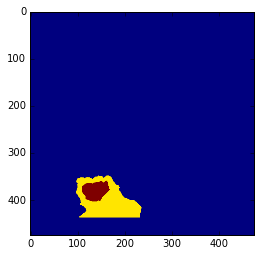

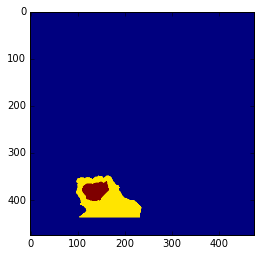

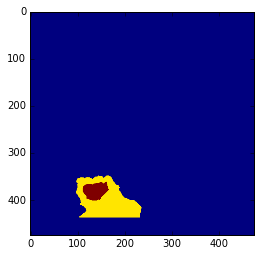

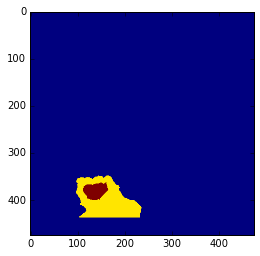

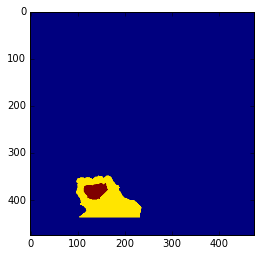

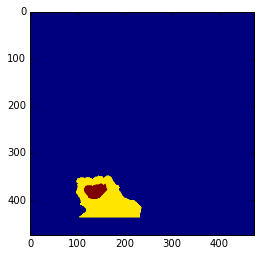

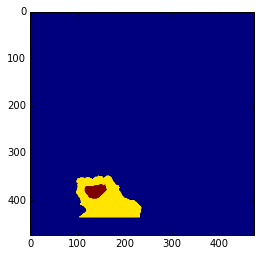

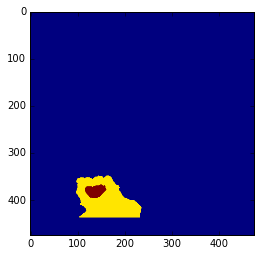

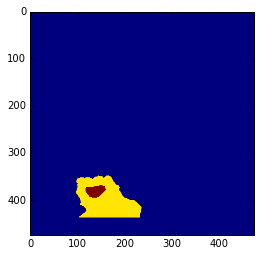

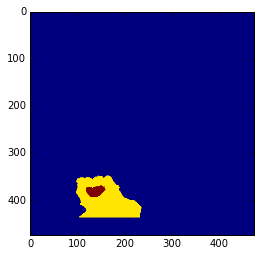

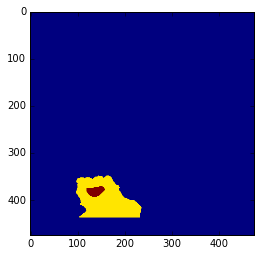

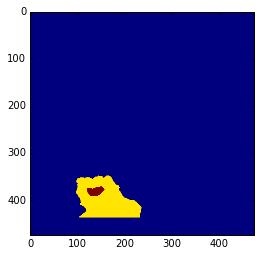

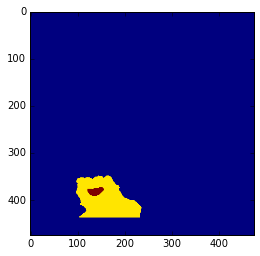

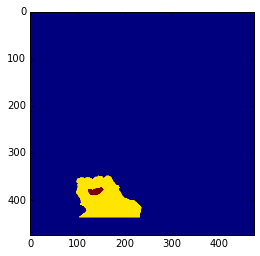

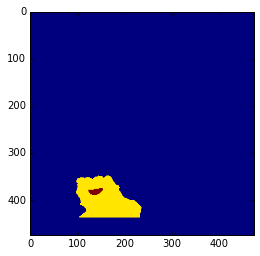

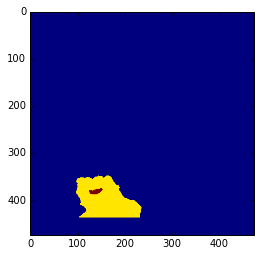

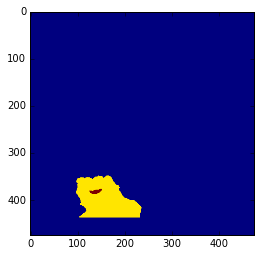

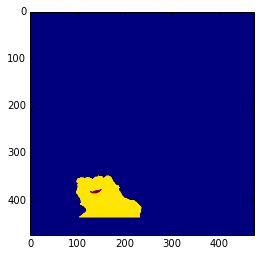

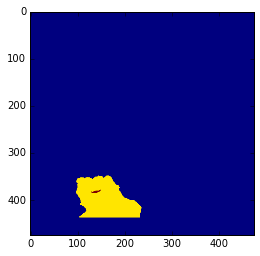

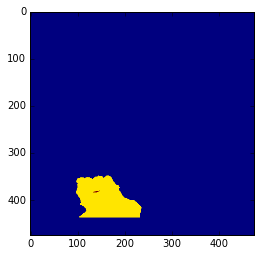

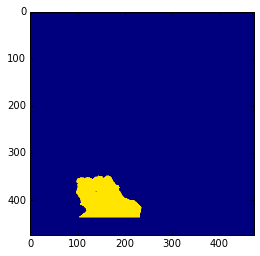

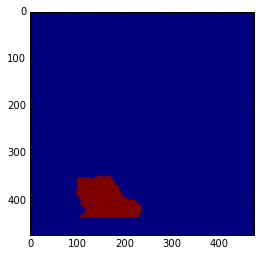

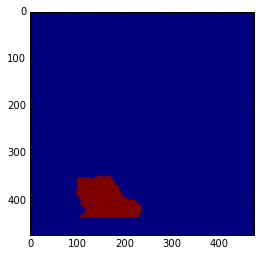

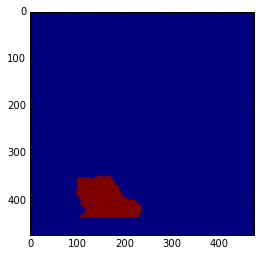

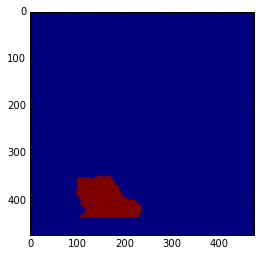

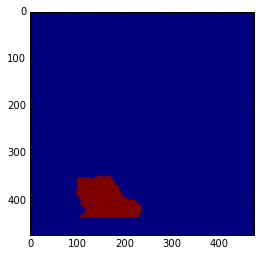

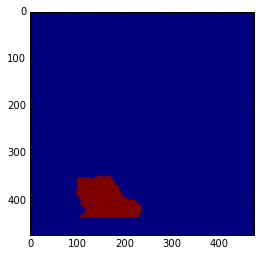

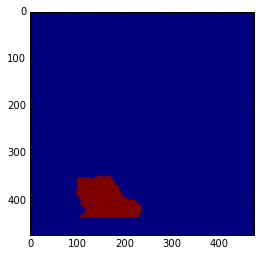

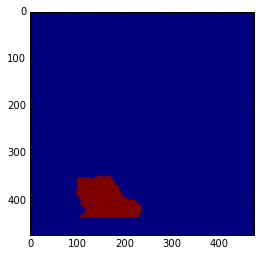

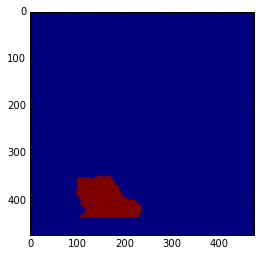

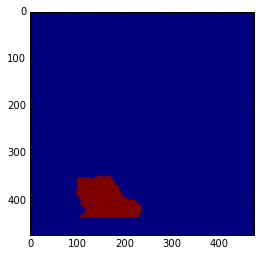

In [31]:
mask = test==5
mask_orig = mask.copy()
values_ri = []

for i in xrange(40):
    mask = mahotas.erode(mask)
    ri = partition_comparison.rand_index((mask+binary).astype(np.uint64).ravel(), gt.astype(np.uint64).ravel())
    #print i, vi
    values_ri.append(ri)
    imshow(mask+binary)
    plt.show()

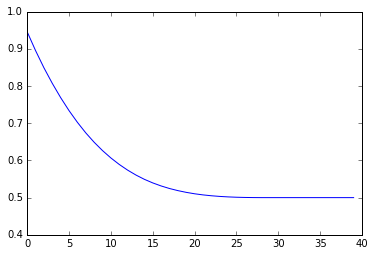

In [33]:
plt.plot(values_ri)

In [51]:
mask = test==5
mask_orig = mask.copy()
values_split_vi = []
values_merge_vi = []
values_f1_vi = []

for i in xrange(1):#(40):
    mask = mahotas.erode(mask)
    v = segmentation_metrics((mask+binary).astype(np.uint64).ravel(), gt.astype(np.uint64).ravel())
    
    #print i, vi
    values_split_vi.append(v['VI']['split'])
    values_merge_vi.append(v['VI']['merge'])    
    values_f1_vi.append(v['VI']['F-score'])    
    
    #imshow(mask+binary)
    #plt.show()

In [53]:
values_split_vi

[0.6018350774867397]

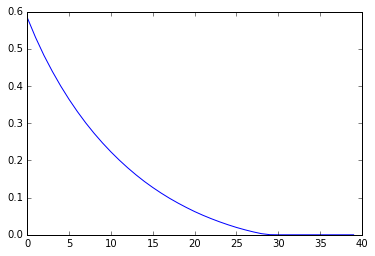

In [49]:
plt.plot(values_merge_vi)

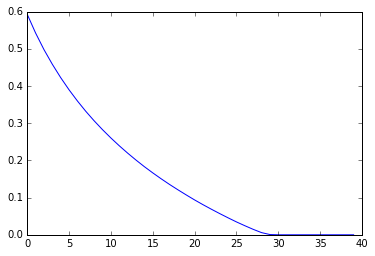

In [50]:
plt.plot(values_f1_vi)

In [40]:
import numpy as np
from scipy.ndimage.filters import maximum_filter
import fast64counter
import mahotas
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import glob
import os
import cPickle

def thin_boundaries(im, mask):
    im = im.copy()
    assert (np.all(im >= 0)), "Label images must be non-negative"

    # make sure image is not all zero
    if np.sum(im) == 0:
       im[:] = 1.0
       im[0,:] = 2.0

    # repeatedly expand regions by one pixel until the background is gone
    while (im[mask] == 0).sum() > 0:
        zeros = (im == 0)
        im[zeros] = maximum_filter(im, 3)[zeros]

    # make sure image is not constant to avoid zero division
    if len(np.unique(im))==1:
        im[0,:] = 5
    return im

def Rand(pair, gt, pred, alpha):
    '''Parameterized Rand score

    Arguments are pairwise fractions, ground truth fractions, and prediction
    fractions.

    Equation 3 from Arganda-Carreras et al., 2015
    alpha = 0 is Rand-Split, alpha = 1 is Rand-Merge

    '''

    return np.sum(pair ** 2) / (alpha * np.sum(gt ** 2) +
                                (1.0 - alpha) * np.sum(pred ** 2))

def VI(pair, gt, pred, alpha):
    ''' Parameterized VI score

    Arguments are pairwise fractions, ground truth fractions, and prediction
    fractions.

    Equation 6 from Arganda-Carreras et al., 2015
    alpha = 0 is VI-Split, alpha = 1 is VI-Merge
    '''

    pair_entropy = - np.sum(pair * np.log(pair))
    gt_entropy = - np.sum(gt * np.log(gt))
    pred_entropy = - np.sum(pred * np.log(pred))
    mutual_information = gt_entropy + pred_entropy - pair_entropy

    vi = mutual_information / ((1.0 - alpha) * gt_entropy + alpha * pred_entropy)
    
    out = [pair_entropy, gt_entropy, pred_entropy, mutual_information, vi]
    
    return out

def segmentation_metrics(ground_truth, prediction, seq=False):
    '''Computes adjusted FRand and VI between ground_truth and prediction.

    Metrics from: Crowdsourcing the creation of image segmentation algorithms
    for connectomics, Arganda-Carreras, et al., 2015, Frontiers in Neuroanatomy

    ground_truth - correct labels
    prediction - predicted labels

    Boundaries (label == 0) in prediction are thinned until gone, then are
    masked to foreground (label > 0) in ground_truth.

    Return value is ((FRand, FRand_split, FRand_merge), (VI, VI_split, VI_merge)).

    If seq is True, then it is assumed that the ground_truth and prediction are
    sequences that should be processed elementwise.

    '''

    # make non-sequences into sequences to simplify the code below
    if not seq:
        ground_truth = [ground_truth]
        prediction = [prediction]

    counter_pairwise = fast64counter.ValueCountInt64()
    counter_gt = fast64counter.ValueCountInt64()
    counter_pred = fast64counter.ValueCountInt64()

    for gt, pred in zip(ground_truth, prediction):
        mask = (gt > 0)
        pred = thin_boundaries(pred, mask)
        gt = gt[mask].astype(np.int32)
        pred = pred[mask].astype(np.int32)
        counter_pairwise.add_values_pair32(gt, pred)
        counter_gt.add_values_32(gt)
        counter_pred.add_values_32(pred)

    # fetch counts
    frac_pairwise = counter_pairwise.get_counts()[1]
    frac_gt = counter_gt.get_counts()[1]
    frac_pred = counter_pred.get_counts()[1]

    # normalize to probabilities
    frac_pairwise = frac_pairwise.astype(np.double) / frac_pairwise.sum()
    frac_gt = frac_gt.astype(np.double) / frac_gt.sum()
    frac_pred = frac_pred.astype(np.double) / frac_pred.sum()

    alphas = {'F-score': 0.5, 'split': 0.0, 'merge': 1.0}

    Rand_scores = {k: Rand(frac_pairwise, frac_gt, frac_pred, v) for k, v in alphas.items()}
    VI_scores = {k: VI(frac_pairwise, frac_gt, frac_pred, v) for k, v in alphas.items()}

    return {'Rand': Rand_scores, 'VI': VI_scores}


# Just doing one, so the interface is easier for the network training
# And yes that means I should refactor the function above... when I have time
def quick_Rand(gt, pred, seq=False):
    counter_pairwise = fast64counter.ValueCountInt64()
    counter_gt = fast64counter.ValueCountInt64()
    counter_pred = fast64counter.ValueCountInt64()

    mask = (gt > 0)
    pred = thin_boundaries(pred, mask)
    gt = gt[mask].astype(np.int32)
    pred = pred[mask].astype(np.int32)
    counter_pairwise.add_values_pair32(gt, pred)
    counter_gt.add_values_32(gt)
    counter_pred.add_values_32(pred)

    # fetch counts
    frac_pairwise = counter_pairwise.get_counts()[1]
    frac_gt = counter_gt.get_counts()[1]
    frac_pred = counter_pred.get_counts()[1]

    # normalize to probabilities
    frac_pairwise = frac_pairwise.astype(np.double) / frac_pairwise.sum()
    frac_gt = frac_gt.astype(np.double) / frac_gt.sum()
    frac_pred = frac_pred.astype(np.double) / frac_pred.sum()

    return Rand(frac_pairwise, frac_gt, frac_pred, 0.5)

def Rand_membrane_prob(im_pred, im_gt):
    Rand_score = []
    for thresh in np.arange(0,1,0.1):
        # white regions, black boundaries
        im_seg = im_pred>thresh
        # connected components
        seeds, nr_regions = mahotas.label(im_seg)
        result = quick_Rand(im_gt, seeds)        
        Rand_score.append(result)

    return np.max(Rand_score)

def run_evaluation_boundary_predictions(network_name):
    pathPrefix = './AC4_small/'
    img_gt_search_string = pathPrefix + 'labels/*.tif'
    img_pred_search_string = pathPrefix + 'boundaryProbabilities/'+network_name+'/*.tif'

    img_files_gt = sorted( glob.glob( img_gt_search_string ) )
    img_files_pred = sorted( glob.glob( img_pred_search_string ) )

    allVI = []
    allVI_split = []
    allVI_merge = []

    allRand = []
    allRand_split = []
    allRand_merge = []

    for i in xrange(np.shape(img_files_pred)[0]):
        print img_files_pred[i]
        im_gt = mahotas.imread(img_files_gt[i])
        im_pred = mahotas.imread(img_files_pred[i])
        im_pred = im_pred / 255.0

        VI_score = []
        VI_score_split = []
        VI_score_merge = []

        Rand_score = []
        Rand_score_split = []
        Rand_score_merge = []
    
        start_time = time.clock()

        for thresh in np.arange(0,1,0.05):
            # white regions, black boundaries
            im_seg = im_pred>thresh
            # connected components
            seeds, nr_regions = mahotas.label(im_seg)
            
            result = segmentation_metrics(im_gt, seeds, seq=False)   
            
            VI_score.append(result['VI']['F-score'])
            VI_score_split.append(result['VI']['split'])
            VI_score_merge.append(result['VI']['merge'])

            Rand_score.append(result['Rand']['F-score'])
            Rand_score_split.append(result['Rand']['split'])
            Rand_score_merge.append(result['Rand']['merge'])

        print "This took in seconds: ", time.clock() - start_time

        allVI.append(VI_score)
        allVI_split.append(VI_score_split)
        allVI_merge.append(VI_score_merge)

        allRand.append(Rand_score)
        allRand_split.append(Rand_score_split)
        allRand_merge.append(Rand_score_merge)
        
    with open(pathPrefix+network_name+'.pkl', 'wb') as file:
        cPickle.dump((allVI, allVI_split, allVI_merge, allRand, allRand_split, allRand_merge), file)
    

    # for i in xrange(len(allVI)):
    #     plt.plot(np.arange(0,1,0.05), allVI[i], 'g', alpha=0.5)
    # plt.plot(np.arange(0,1,0.05), np.mean(allVI, axis=0), 'r')
    # plt.show()
    
def run_evaluation_segmentations3D():
    # first test how to convert a great boundary segmentation quickly into 3d objects
    pathPrefix = './AC4/'
    img_gt_search_string = pathPrefix + 'labels/*.tif'
    img_pred_search_string = pathPrefix + 'boundaryProbabilities/IDSIA/*.tif'

    img_files_gt = sorted( glob.glob( img_gt_search_string ) )
    img_files_pred = sorted( glob.glob( img_pred_search_string ) )
    
    s = 100
    img_gt_volume = np.zeros((1024,1024,s))
    img_pred_volume = np.zeros((1024,1024,s))

    for i in xrange(s):
        print img_files_gt[i]
        # read image
        img_gt = mahotas.imread(img_files_gt[i])
        img_gt_volume[:,:,i] = img_gt
        # compute gradient to get perfect segmentation
        img_gt = np.gradient(img_gt)
        img_gt = np.sqrt(img_gt[0]**2 + img_gt[1]**2)
        #img_gt = mahotas.morph.erode(img_gt == 0)
        img_pred_volume[:,:,i] = img_gt == 0


    all_VI = []
    for i in xrange(20):
        print i
        if i>0:
            for j in xrange(s):
                img_pred_volume[:,:,j] = mahotas.morph.erode(img_pred_volume[:,:,j]>0)

    # connected component labeling
    print "labeling"
    seeds, nr_objects = mahotas.label(img_pred_volume)
    # compute scores
    print "computing metric"
    result = segmentation_metrics(img_gt_volume, seeds, seq=False)   
    print result
    all_VI.append(result['VI']['F-score'])
    return seeds
